---
The objective here is to identify where a vehicle's license plate is and then recognize the Digits and Letters on it.
---
---

# Imports

In [98]:
!pip install easyocr
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [99]:
# Library to text detection from images
import easyocr
# Library to help with contours of the image
import imutils
# Library to detect objects (detect where the plate is)
import cv2

import numpy as np
import matplotlib.pyplot as plt

# 1. Read in Image, Grayscale and Blur

In [100]:
def stage1( image ):
  '''Function to read, grayscale and show image'''
  
  # --------------------------------------------------------------------------
  # Read image

  # Img Google Drive path
  pkg_dir = "/content/drive/Shareddrives/9_topin | Pesquisa e Desenvolvimento/8_IA/1_Estudos/OCR-01/images-test"
  img = cv2.imread( f'{pkg_dir}/{image}' )

  # --------------------------------------------------------------------------
  # Gray scaling

  # convert blue, green, red into gray
  gray = cv2.cvtColor( img, cv2.COLOR_BGR2GRAY ) 

  # --------------------------------------------------------------------------
  # Show image

  imgshow = plt.imshow( cv2.cvtColor( gray, cv2.COLOR_BGR2RGB ))

  # --------------------------------------------------------------------------
  return img, gray, imgshow

# 2. Apply filter and find edges for localization

In [101]:
def stage2( image ):
  '''function to reduce noise in image, detect edges and show filtered image'''

  gray = stage1( image )[1]

  # --------------------------------------------------------------------------
  # Noise reduction
  
  bfilter = cv2.bilateralFilter( gray, 11, 17, 17 ) # the arguments show how intense we want the noise reduction

  # --------------------------------------------------------------------------
  # Edge detection with Canny algorithm

  edged = cv2.Canny( bfilter, 30, 200 )

  # --------------------------------------------------------------------------
  # Image filtered show

  imgshow = plt.imshow( cv2.cvtColor( edged, cv2.COLOR_BGR2RGB ) )

  # --------------------------------------------------------------------------
  return edged, imgshow

# 3. Find Contours and Apply Mask

In [102]:
def stage3( image ):
  '''Function to find the contours of the image
  and Apply a gray mask'''

  img = stage1( image )[0]
  gray = stage1( image )[1]
  edged = stage2( image )[0]

  # --------------------------------------------------------------------------
  # Finding the edge with a approximate contour

  keypoints = cv2.findContours( edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE )

  # Simplifying how a contour looks like
  contours = imutils.grab_contours( keypoints )

  # Returning the top 10 contours
  contours = sorted( contours, key = cv2.contourArea, reverse = True )[:10]

  # --------------------------------------------------------------------------
  # Finding the location of the plate

  location = None

  for contour in contours:
    approx = cv2.approxPolyDP( contour, 10, True )
    if len(approx) == 4:
      location = approx
      break

  # --------------------------------------------------------------------------
  # Applying a mask (black) to isolate the area of the plate from the rest of the image

  # Black mask with the same shape as the original gray image
  mask = np.zeros( gray.shape, np.uint8 )

  # Returning a location from the mask
  new_image = cv2.drawContours( mask, [location], 0, 255, -1 )

  # Overlay the mask over the original image
  new_image = cv2.bitwise_and( img, img, mask = mask )

  imgshow1 = plt.imshow( cv2.cvtColor( new_image, cv2.COLOR_BGR2RGB ) )

  # --------------------------------------------------------------------------
  # Isolating the section with the plate only

  ( x, y ) = np.where( mask == 255 )
  ( x1, y1 ) = ( np.min(x), np.min(y) )
  ( x2, y2 ) = ( np.max(x), np.max(y) )

  cropped_image = gray[ x1: x2+1, y1: y2+1] # +1 to give a buffer

  # --------------------------------------------------------------------------
  # Image show

  imgshow2 = plt.imshow( cv2.cvtColor( cropped_image, cv2.COLOR_BGR2RGB ) )

  # --------------------------------------------------------------------------
  return approx, location, cropped_image, imgshow1, imgshow2

# 4. Use Easy OCR to read text

In [103]:
# Creating a reader object
reader = easyocr.Reader(['en'])

def stage4( image ):
  '''Function to read the text in the plate'''

  cropped_image = stage3( image )[2]

  # --------------------------------------------------------------------------
  # Using the reader in English to read the context in the cropped image

  result = reader.readtext( cropped_image )
  
  # --------------------------------------------------------------------------
  return result

# 5. Render result

In [104]:
def stage5( image ):
  '''Function to render the result overlaying the result over the
  original image'''
  
  img = stage1( image )[0]
  approx = stage3( image )[0]
  result = stage4( image )

  # --------------------------------------------------------------------------
  # Returning the text content from stage 4

  text = result[0][-2]
  
  # Overlaying the result with a text
  font = cv2.FONT_HERSHEY_SIMPLEX
  res = cv2.putText( img, text = text, org = ( approx[0][0][0], approx[1][0][1]+60 ),
                      fontFace = font, fontScale = 1, color = (0, 255, 0),
                      thickness = 2, lineType = cv2.LINE_AA )
  
  # Drawn rectangle
  res = cv2.rectangle( img, tuple( approx[0][0]), tuple(approx[2][0] ), (0,255,0), 3 )

  # --------------------------------------------------------------------------
  # Image show

  imgshow = plt.imshow( cv2.cvtColor( res, cv2.COLOR_BGR2RGB ) )
  
  # --------------------------------------------------------------------------
  return imgshow

# Test-images

## img1

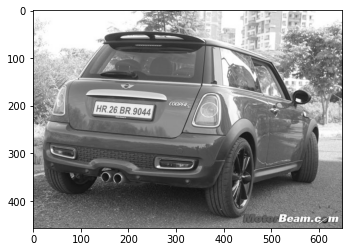

In [105]:
stage1( 'image1.jpg' )[2]

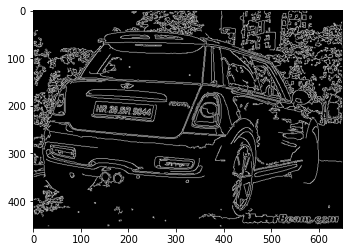

In [106]:
stage2( 'image1.jpg' )[1]

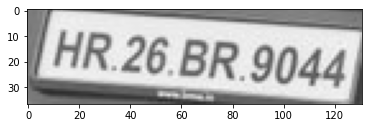

In [107]:
stage3( 'image1.jpg' )[4]

[([[6, 4], [128, 4], [128, 34], [6, 34]], 'HR.26 BR.9044', 0.572802443929149)]

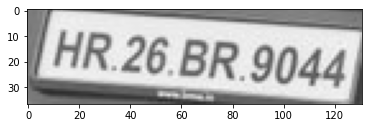

In [108]:
stage4( 'image1.jpg' )

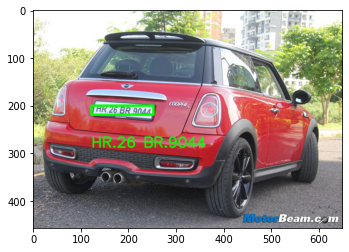

In [109]:
stage5( 'image1.jpg' )

<h3>In this scenarie, the plate was correct identified.<h3>

## img2

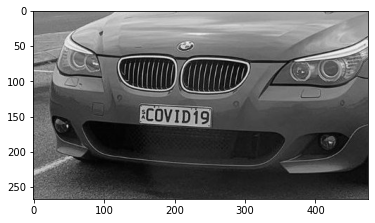

In [110]:
stage1( 'image2.jpg' )[2]

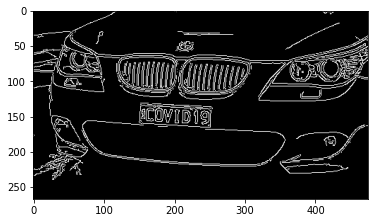

In [111]:
stage2( 'image2.jpg' )[1]

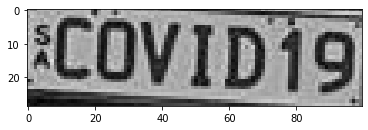

In [112]:
stage3( 'image2.jpg' )[4]

[([[0, 0], [100, 0], [100, 29], [0, 29]], 'ICOVIDT9', 0.5275640804797114)]

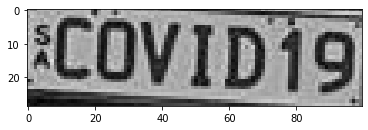

In [113]:
stage4( 'image2.jpg' )

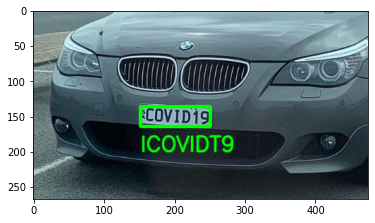

In [114]:
stage5( 'image2.jpg' )

<h3>In this scenarie, the plate was almost correct identified.<br> The algorithm missclassified the letters 'sa' with '|'.<h3>

## img3

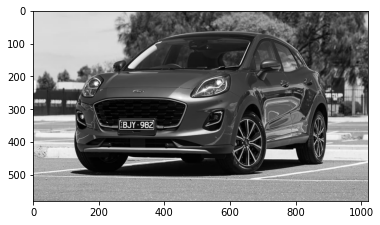

In [115]:
stage1( 'image3.jpg' )[2]

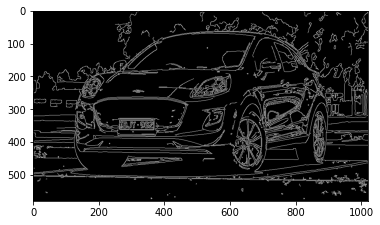

In [116]:
stage2( 'image3.jpg' )[1]

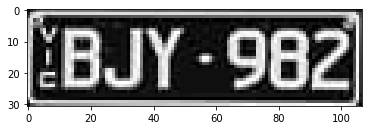

In [117]:
stage3( 'image3.jpg' )[4]

[([[0, 2], [107, 2], [107, 31], [0, 31]], 'EBJY. 982]', 0.3741937983327902)]

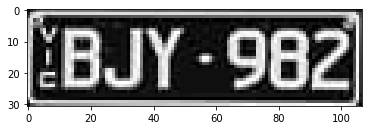

In [118]:
stage4( 'image3.jpg' )

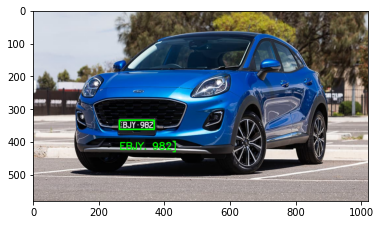

In [119]:
stage5( 'image3.jpg' )

<h3>In this scenarie, the plate was almost correct identified.<br> The algorithm didn't read the letters 'vic'.<h3>

## img4

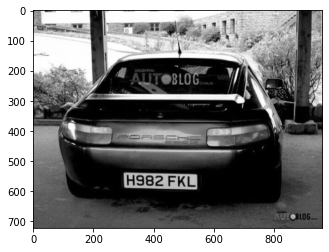

In [120]:
stage1( 'image4.jpg' )[2]

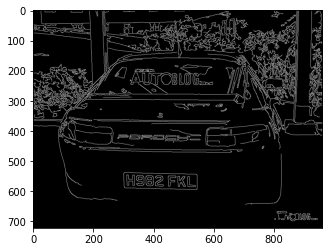

In [121]:
stage2( 'image4.jpg' )[1]

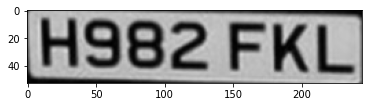

In [122]:
stage3( 'image4.jpg' )[4]

[([[0, 0], [244, 0], [244, 53], [0, 53]], 'H982 FKL', 0.9769778851628141)]

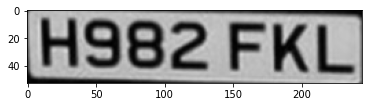

In [123]:
stage4( 'image4.jpg' )

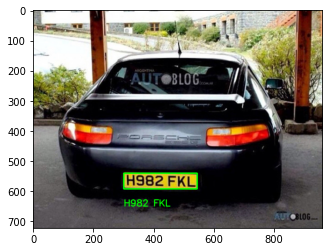

In [124]:
stage5( 'image4.jpg' )

<h3>In this scenarie, the plate was correct identified.<h3>

## img5

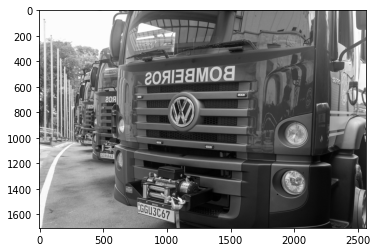

In [125]:
stage1( 'image5.jpg' )[2]

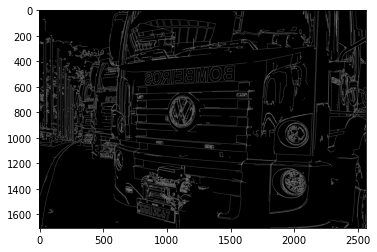

In [126]:
stage2( 'image5.jpg' )[1]

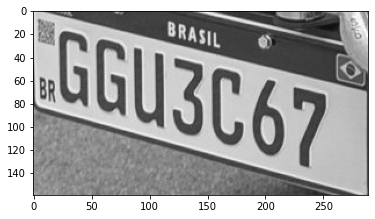

In [127]:
stage3( 'image5.jpg' )[4]

[([[3, 55], [23, 55], [23, 79], [3, 79]], 'BR', 0.7430508679989368),
 ([[112.4034500137281, 3.0910400439299406],
   [168.98559122601995, 16.760359679618283],
   [163.5965499862719, 38.908959956070056],
   [107.01440877398007, 24.239640320381717]],
  'brasil',
  0.6756060185282295),
 ([[21.193354126603403, -2.970383878193699],
   [279.98468139994577, 68.41967720905947],
   [251.8066458733966, 154.9703838781937],
   [-6.984681399945789, 83.58032279094053]],
  'GGu3C6z',
  0.36049331646753285)]

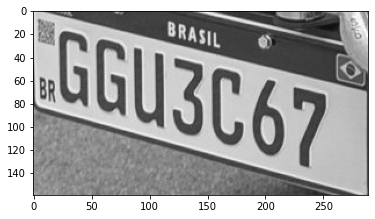

In [128]:
stage4( 'image5.jpg' )

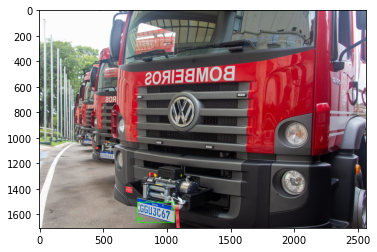

In [129]:
stage5( 'image5.jpg' )

<h3>In this scenarie, the plate was almost correct identified.<br> The algorithm missclassified the number '7' with 'z'.<h3>

## img6

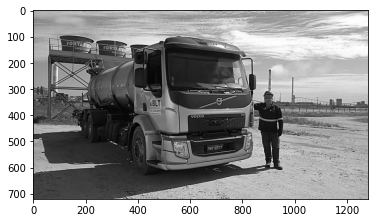

In [130]:
stage1( 'image6.jpg' )[2]

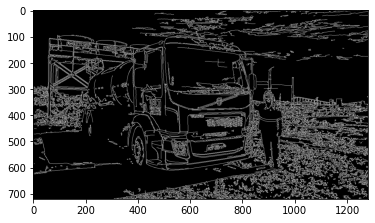

In [131]:
stage2( 'image6.jpg' )[1]

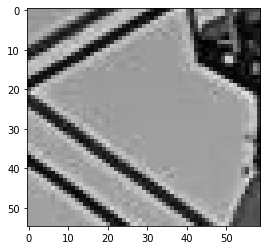

In [132]:
stage3( 'image6.jpg' )[4]

[]

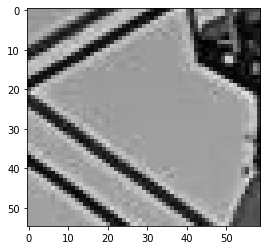

In [133]:
stage4( 'image6.jpg' )

IndexError: ignored

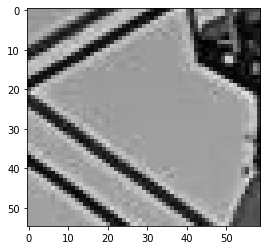

In [134]:
stage5( 'image6.jpg' )

<h3>In this scenarie, the algorith couldn't find the plate.<h3>

## img7

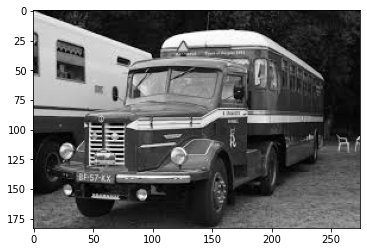

In [135]:
stage1( 'image7.jpg' )[2]

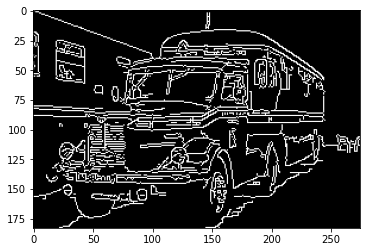

In [136]:
stage2( 'image7.jpg' )[1]

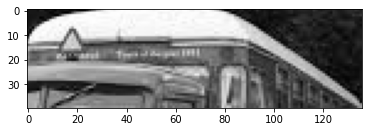

In [137]:
stage3( 'image7.jpg' )[4]

[]

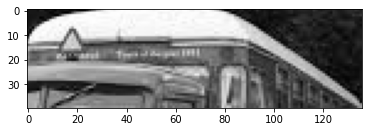

In [138]:
stage4( 'image7.jpg' )

IndexError: ignored

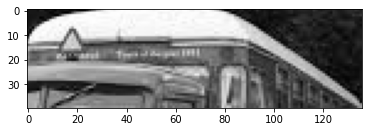

In [139]:
stage5( 'image7.jpg' )

<h3>In this scenarie, the algorith couldn't find the plate.<h3>

## img8

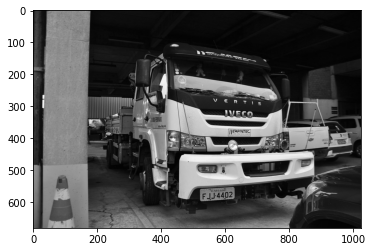

In [140]:
stage1( 'image8.jpg' )[2]

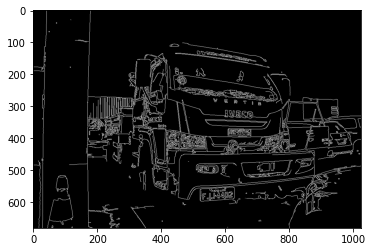

In [141]:
stage2( 'image8.jpg' )[1]

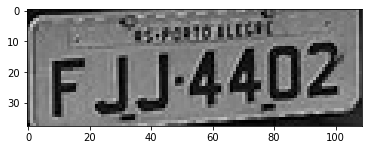

In [142]:
stage3( 'image8.jpg' )[4]

[([[15, 3], [108, 3], [108, 38], [15, 38]], '44402', 0.844296045285203)]

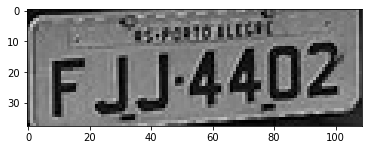

In [143]:
stage4( 'image8.jpg' )

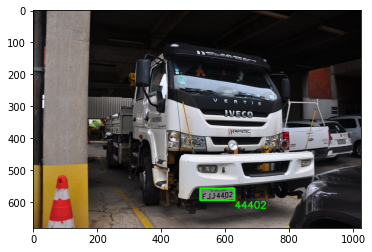

In [144]:
stage5( 'image8.jpg' )

<h3>In this scenarie, the algorith didn't read the letters 'FJJ'.<h3>

## img9

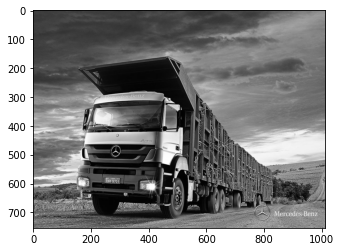

In [145]:
stage1( 'image9.jpg' )[2]

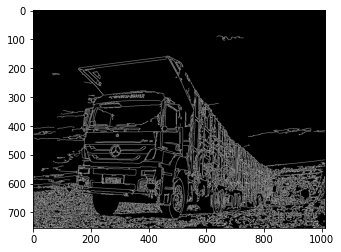

In [146]:
stage2( 'image9.jpg' )[1]

error: ignored

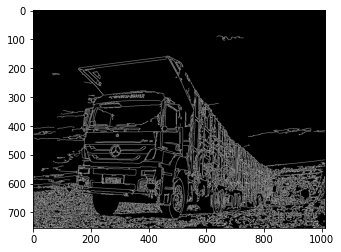

In [147]:
stage3( 'image9.jpg' )[4]

error: ignored

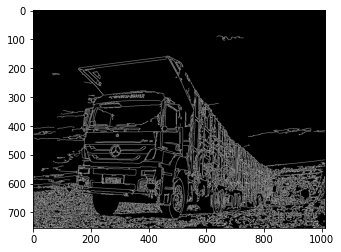

In [148]:
stage4( 'image9.jpg' )

error: ignored

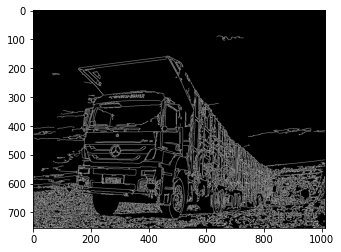

In [149]:
stage5( 'image9.jpg' )

<h3>In this scenarie, the algorith couldn't find the plate.<h3>